## COGS 18 Final Project 

### Leo Megliola 

### 6/8/2022

### Setup Notebook Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

np.set_printoptions(precision=3)
np.seterr(divide='ignore')  # when the position of a body is conpared to itself, the math after will not fail
np.seterr(invalid='ignore') # it's OK to fail when computing a body against itself

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import matplotlib
matplotlib.__version__

'3.5.2'

### Notes on running animation

1. I start Juptyer locally using: jupyter notebook --NotebookApp.iopub_data_rate_limit=100000
2. I am using matplotlib version 3.5.2 on a mac (locally)
3. Only run one plot at a time (make sure to manually end the prior one before moving on)
4. If you want to make your own test cases see end of notebook

### Initial Conditions

These values represent the sun, earth, and moon. The inital condations consist of masses, positions, and velocities, the second two of these three values require 3 dimensions. I also establish the time step (this will be changeable later, but it 1 hour for now) and the number of iterations.

I've made the number of iterations and time step such that this simulation will model steps of 1 hour for 1 year. 

In [3]:
m0 = np.array((1.989e+30,5.972e+24,7.348e+22),dtype=float)
p0 = np.array(((0,0,0),(1.496e+11,0,0),(1.496e+11+384.4e+6,0,0)),dtype=float)
v0 = np.array(((0,0,0),(0,29785.67,0),(0,29785.67+1.022e+3,0)),dtype=float)
dt = 60*60  # 60 seconds/minute, 60 minutes/hour
N = 365*24  # 365 days x 24 hours/day

### Constants

G of course from universial gravition.

X,Y,Z will make the code later on more readable; insted of remembering that list[0] is the X-coordanate, it will be more clear to see list[X]. 

In [4]:
G = 6.67408e-11
X, Y, Z = 0, 1, 2

### The Relavent Equations:

#### Gravity

gravitational force between body j and each body k
$$F_{j_k}=G \frac {m_j m_k}{d_{jk}^2}$$

#### Distance in 3D Cartesian System

distance between body j and each body k
$$d_{jk}=\sqrt{(x_k-x_j)^2+(y_k-y_j)^2+(z_k-z_j)^2}$$

## A Single Step of Simulation

### Difference in Position

To begin, I will need to know the difference in position from each body to each other body in each dimension. So, for three bodies, in three dimensions that will be $3^3 = 27$ entries total. Noteably, this will have a few limitations in terms of efficiency. First: it will compare the difference from a body to itself (obviously a wasted computation). Second: it will compare body A to B but will also do B to A (more wasted computation). 

Overall, these tradeoffs are worth the simplicity of the code (both in reading and linear algebra). 

In [5]:
p = p0  # take the initial conditions from above
# this is essentially nested for loops to do the comparison described above
d_xyz = np.array([[p[i, j] - p[:, j] for i in range(p.shape[0])] for j in range(3)])
print(d_xyz.shape)
d_xyz

(3, 3, 3)


array([[[ 0.000e+00, -1.496e+11, -1.500e+11],
        [ 1.496e+11,  0.000e+00, -3.844e+08],
        [ 1.500e+11,  3.844e+08,  0.000e+00]],

       [[ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00]],

       [[ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00]]])

### Total Distance

I just found the difference in position between bodies, but to apply universial gravation I need the total distance from each body to each other body. To accomplish this, I am using the formula from above: the square root of the sum of squares of difference in position in each dimention.

From this point forward, the main diagonal is not informative and should be ignored. It corresponds to the self-comparisons discussed above and will be dealt with later on. This artifact will be carried through the next few steps. 

In [6]:
d = np.sqrt(d_xyz[X]**2 + d_xyz[Y]**2 + d_xyz[Z]**2)
d

array([[0.000e+00, 1.496e+11, 1.500e+11],
       [1.496e+11, 0.000e+00, 3.844e+08],
       [1.500e+11, 3.844e+08, 0.000e+00]])

### A Small Optimization

Universal gravation constantly uses $m_j * m_k$, so instead of finding this product every time I calculate force, I will do the math upfront. I will take the product of each mass with each other mass using an outer product. That way I have these products stored in an array. This will have a similar issue to difference in position in that it will find the product of each mass with itself which is unecesessary, but I would rather waste that compuation than find the necessary products thousands of times. 

In [7]:
m = m0
m_outer = np.outer(m, m)
m_outer

array([[3.956e+60, 1.188e+55, 1.462e+53],
       [1.188e+55, 3.566e+49, 4.388e+47],
       [1.462e+53, 4.388e+47, 5.399e+45]])

### Force 

I now have all the necessary ingredients for universal gravitation, so it's time to compute the force between all objects. This is exactly Newton's universal gravitation, because of the way the arrays are shaped, this reads exactly like a single line of math. Again, because the arrays carry information about all bodies there is no need for loops.

In [8]:
F = G * m_outer / d**2  # m_outer is m_j x m_k
F

array([[      inf, 3.542e+22, 4.336e+20],
       [3.542e+22,       inf, 1.982e+20],
       [4.336e+20, 1.982e+20,       inf]])

### Acceleration $\Delta a_{step}$

I now have forces and masses. Via Newton's second law of motion: $F = ma$, the acceleration: $a= F/m$ can be found. This is the acceleration each body experiences from the gravity of each other body.

In [9]:
a = F / m
a

array([[      inf, 5.931e-03, 5.901e-03],
       [1.781e-08,       inf, 2.697e-03],
       [2.180e-10, 3.319e-05,       inf]])

### A Change in Velocity $\Delta v_{step}$

Now that I have acceleration, I can find the change in velocity in each dimension, for each body acting upon each other body, during this step. To scale acceleration, distances must be normalized into unit vectors:

In [10]:
d_xyz/d

array([[[nan, -1., -1.],
        [ 1., nan, -1.],
        [ 1.,  1., nan]],

       [[nan,  0.,  0.],
        [ 0., nan,  0.],
        [ 0.,  0., nan]],

       [[nan,  0.,  0.],
        [ 0., nan,  0.],
        [ 0.,  0., nan]]])

Then using the unit vectors, I can find each change in velocity: $\Delta \vec v = \Delta \vec a \Delta t$

In [11]:
v_xyz = a * (d_xyz/d) * dt
v_xyz

array([[[       nan, -2.135e+01, -2.124e+01],
        [ 6.411e-05,        nan, -9.711e+00],
        [ 7.848e-07,  1.195e-01,        nan]],

       [[       nan,  0.000e+00,  0.000e+00],
        [ 0.000e+00,        nan,  0.000e+00],
        [ 0.000e+00,  0.000e+00,        nan]],

       [[       nan,  0.000e+00,  0.000e+00],
        [ 0.000e+00,        nan,  0.000e+00],
        [ 0.000e+00,  0.000e+00,        nan]]])

### Total Change in Velocity

I find the total change in velocity for each body by summing the change caused on that body by each other body. To eliminate the artifacts, I use np.isnan to identify artifacts:

In [12]:
np.isnan(v_xyz)

array([[[ True, False, False],
        [False,  True, False],
        [False, False,  True]],

       [[ True, False, False],
        [False,  True, False],
        [False, False,  True]],

       [[ True, False, False],
        [False,  True, False],
        [False, False,  True]]])

I then negate that to include non-nan and exclude nan values:

In [13]:
~np.isnan(v_xyz)

array([[[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]],

       [[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]],

       [[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]]])

Then I use np.where as an argument to np.sum to only perform summation where the truth array indicates true. This process efficitely eliminates all artifacts from this point forward:

In [14]:
dv_xyz = v_xyz.sum(axis=1, where=~np.isnan(v_xyz))
dv_xyz

array([[ 6.490e-05, -2.123e+01, -3.095e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00]])

### Update Velocities and Positions

As a last step, I update values and positions by adding incremental changes to current values:
$$ \vec v_{new} =  \vec v + \Delta \vec v$$
$$ \vec p_{new} = \vec p+ \Delta \vec v  dt$$


In [15]:
v = v0
v += dv_xyz.T  # transpose because sum() changed orientation
v

array([[ 6.490e-05,  0.000e+00,  0.000e+00],
       [-2.123e+01,  2.979e+04,  0.000e+00],
       [-3.095e+01,  3.081e+04,  0.000e+00]])

In [16]:
p = p0
p += v * dt
p

array([[2.336e-01, 0.000e+00, 0.000e+00],
       [1.496e+11, 1.072e+08, 0.000e+00],
       [1.500e+11, 1.109e+08, 0.000e+00]])

### Now, to put it all together:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

np.set_printoptions(precision=3)
np.seterr(divide='ignore')  
np.seterr(invalid='ignore') 

# this function runs the entire sequence and returns positions for each body
def simulate(m, p, v, dt, n): # perduces all the steps for a simulation in one shot
    traces = [np.empty((3, n)) for i in range(len(m))]  
    G = 6.67408e-11
    X, Y, Z = 0, 1, 2
    m_outer = np.outer(m, m)

    for i in range(n):
        d_xyz = np.array([[p[i, j] - p[:, j] for i in range(p.shape[0])] for j in range(3)])
        d = np.sqrt(d_xyz[X]**2 + d_xyz[Y]**2 + d_xyz[Z]**2)
        F = G * m_outer / d**2
        a = F / m
        v_xyz = a * (d_xyz/d) * dt
        dv_xyz = v_xyz.sum(axis=1, where=~np.isnan(v_xyz))
        v += dv_xyz.T
        p += v * dt
        for j in range(len(m)):
            traces[j][:, i] = p[j]  # capture position x,y,z for m bodies for i-th period

    return traces

### For the animation code, I got this from the URL in the first line's comment

There is no meaningfull way to rewrite this myself, but I can tweak some of the perameters to make the plots come out a little differently. The code is the 3d animation example from matplotlib.

In [18]:
# from https://matplotlib.org/2.1.2/gallery/animation/simple_3danim.html
def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

def plot(traces, lim):
    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    lines = [ax.plot(xyz[0, 0:1], xyz[1, 0:1], xyz[2, 0:1], linewidth=0, marker='o')[0] for xyz in traces]

    # Setting the axes properties
    ax.set_xlim3d([-lim,lim])
    ax.set_xlabel('X')

    ax.set_ylim3d([-lim,lim])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-lim,lim])
    ax.set_zlabel('Z')

    ax.set_title('3D Test')

    # Creating the Animation object
    line_ani = animation.FuncAnimation(fig, update_lines, fargs=(traces, lines), interval=0.01, blit=True)
    return line_ani # keep this object in scope until animation is complete

### Now to do some testing

First, try three equally massive objects at rest:

<IPython.core.display.Javascript object>


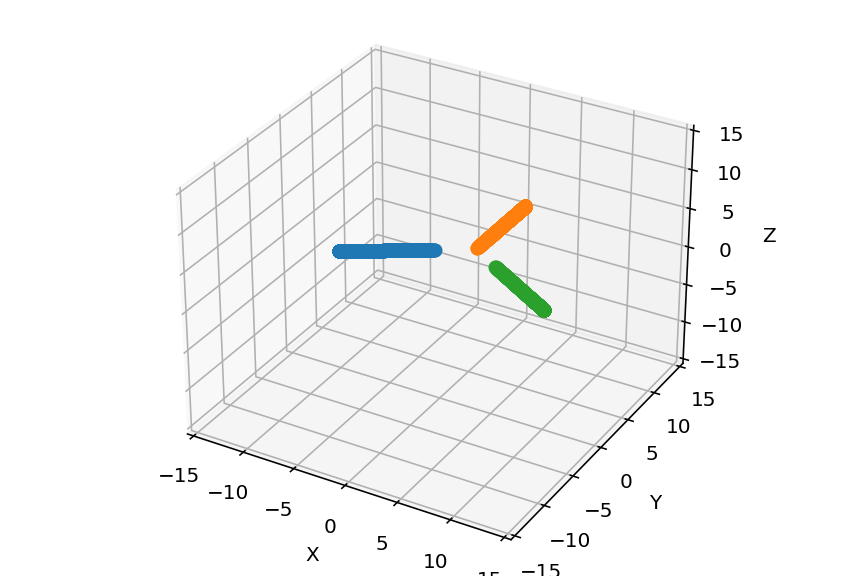

In [20]:
m0 = np.array((10**8,10**8,10**8),dtype=float)
p0 = np.array(((-10,0,0),(0,15,0),(10,0,0)),dtype=float)
v0 = np.array(((0,0,0),(0,0,0),(0,0,0)),dtype=float)
dt = 1
N = 600

ani = plot(simulate(m0,p0,v0,dt,N),15)
plt.show()

So these masses demonstrate acceleration from rest.

Next, try the sun, earth, and moon:

<IPython.core.display.Javascript object>


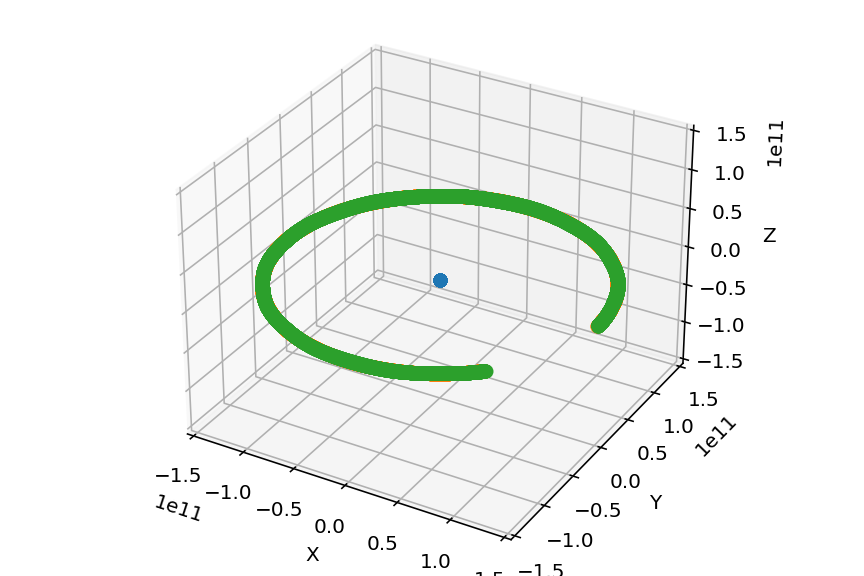

In [20]:
m0 = np.array((1.989e+30,5.972e+24,7.348e+22),dtype=float)
p0 = np.array(((0,0,0),(1.496e+11,0,0),(1.496e+11+384.4e+6,0,0)),dtype=float)
v0 = np.array(((0,0,0),(0,29785.67,0),(0,29785.67+1.022e+3,0)),dtype=float)
dt = 60*60
N = 365*24

traces = simulate(m0,p0,v0,dt,N)
ani = plot(traces,1.5*10**11)
plt.show()

The moon does not appear on this scale, because the lines are plotted over one another. Here is a fragment of the earth and moon in the x-y plane:

<IPython.core.display.Javascript object>


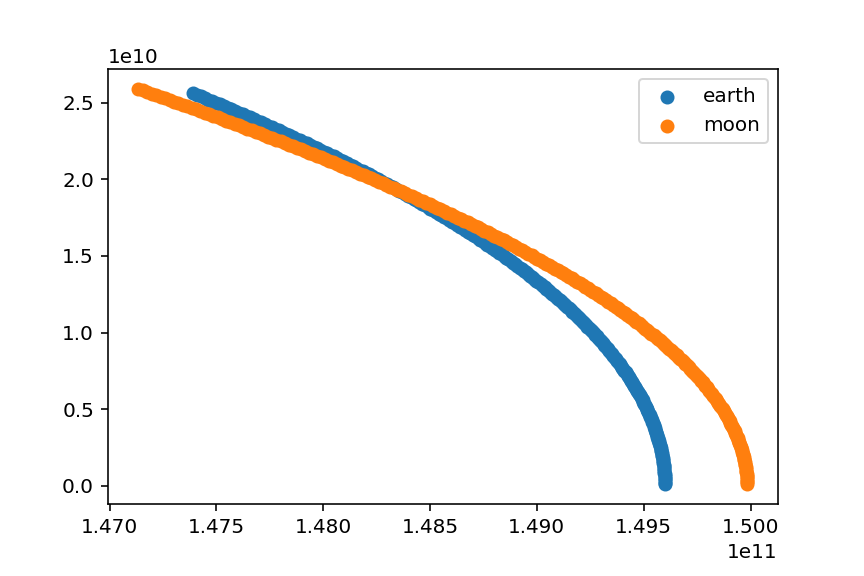

In [21]:
hours,days = 24,10
steps = hours*days  
plt.scatter(traces[1][0,0:steps],traces[1][1,0:steps], label='earth')
plt.scatter(traces[2][0,0:steps],traces[2][1,0:steps], label='moon')
plt.legend()
plt.show()

This is the position of the earth and moon over 10 days.

Here is the difference between the earth and moon $x_{earth}-x_{moon}$ showing the lunar month.

<IPython.core.display.Javascript object>


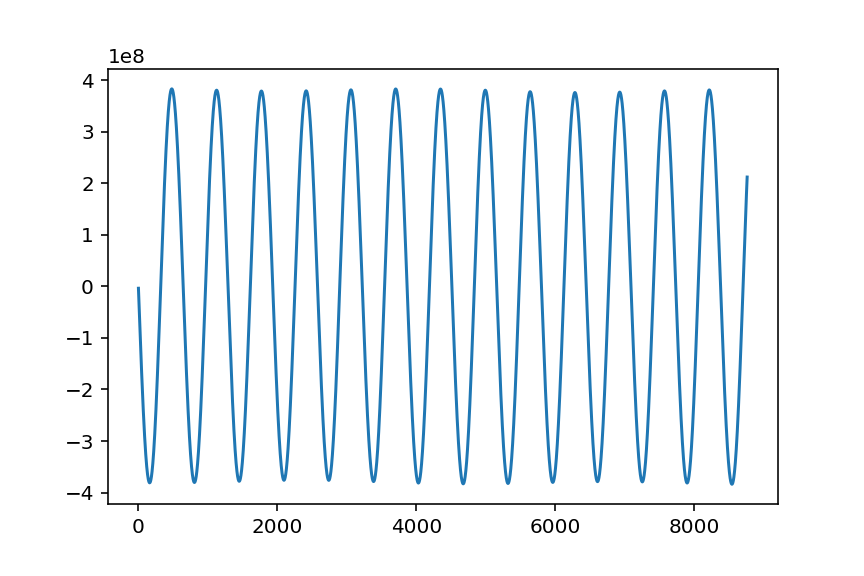

In [23]:
plt.plot(traces[1][1,:]-traces[2][1,:])

This corresponds to the actual period of the lunar orbit: $\frac{365}{27.3}\approx13.4$, which matches the number of oscillations.

Here are two masses with initial velocities that cause a spiral in a helix (a binary system of orbitting masses):

<IPython.core.display.Javascript object>


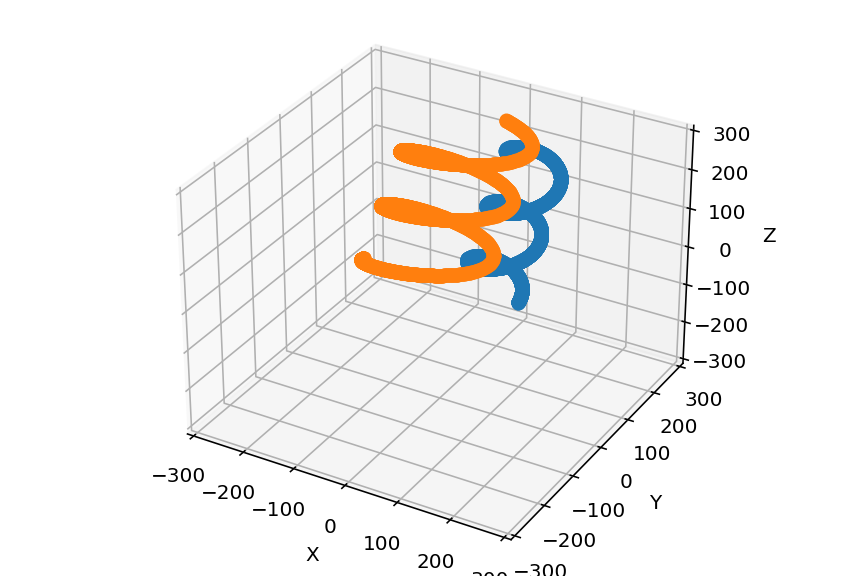

In [24]:
m0 = np.array([10**10*2, 10**10],dtype=float)
p0 = np.array([(150,0,0),(-150,0,0)],dtype=float)
v0 = np.array([(0,.02,0.01),(0,-.02,0.01)],dtype=float)
dt = 10
N = 3000

ani = plot(simulate(m0,p0,v0,dt,N),300)
plt.show()

### Make your own test case

Copy this into a cell, filling in the values.

Each set of parameters is group of ordered lists, each representing one attribute of n bodies (1st, 2nd, ...nth)

```
m0 = np.array([ <m1,m2,m3...> ],dtype=float)
p0 = np.array([ <(x1,y1,z1),(x2,y2,z2),(x3,y3,z3)...> ],dtype=float)
v0 = np.array([ <(x1,y1,z1),(x2,y2,z2),(x3,y3,z3)...> ],dtype=float)
dt = <enter dt in seconds>
N = <number of iterations>

ani = plot(simulate(m0,p0,v0,dt,N), )
plt.show()
```

In [ ]:
# edit this code
m0 = np.array([ <m1,m2,m3...> ],dtype=float)
p0 = np.array([ <(x1,y1,z1),(x2,y2,z2),(x3,y3,z3)...> ],dtype=float)
v0 = np.array([ <(x1,y1,z1),(x2,y2,z2),(x3,y3,z3)...> ],dtype=float)
dt = <enter dt in seconds>
N = <number of iterations>

ani = plot(simulate(m0,p0,v0,dt,N), )
plt.show()